In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.detector import Detector
from pycbc.psd import interpolate, inverse_spectrum_truncation, aLIGOZeroDetHighPower
from pycbc.types import TimeSeries, FrequencySeries
import random
import os
from pycbc.frame import read_frame
from tqdm import tqdm
from fnmatch import fnmatch

In [39]:
class WaveformPosterior:
    def __init__(self,  
                 average_method = 'median', 
                 credible_interval=90, 
                 n_samples=100, 
                 detector='L1', 
                 f_lower=20, 
                 delta_t=1/1024, 
                 use_pol_inj_value=np.pi/3):
        """
        detector: str, default = L1
            name of the detector. Eg. L1
        f_lower: float, default = 20
            low frequency cut-off for waveform generation
        delta_t: float, default = 1/1024
            time step for waveform generation
        use_pol_inj_value: float, default = pi/3
            injection value of polarization to be used if samples don't contain polarization
        """
        self.average_method = average_method
        self.credible_interval = credible_interval
        self.n_samples = n_samples
        self.detector = detector
        self.f_lower = f_lower
        self.delta_t = delta_t
        self.use_pol_inj_value = use_pol_inj_value

    ##############################################################################################
        
    def load_samples(self, posterior_file, select_method='max_loglikelihood'):
        """
        select_method: str, default = "max_loglikelihood"
            Method to select the samples. Options: "random", "max_loglikelihood"
        """
        print(f'n_samples = {self.n_samples}')
        with h5py.File(posterior_file, "r") as f:
            attr_dict = {key:f.attrs[key] for key in f.attrs}
            if attr_dict['approximant'] == 'TaylorF2Ecc':
                raise Exception('Skipping runs with TaylorF2Ecc')
            all_samples = {param: f['samples'][param][:] for param in f['samples'].keys()}
        if select_method == 'random':
            select_samples = random.sample(range(len(all_samples['mass1'])), self.n_samples)
        elif select_method == 'max_loglikelihood':
            select_samples = all_samples['loglikelihood'].argsort()[-self.n_samples:]
        else:
            raise ValueError('select_method not known')
        samples = {param: all_samples[param][select_samples] for param in all_samples.keys()}
        return(samples, attr_dict)

    ##############################################################################################
    
    def generate_templates(self, posterior_file):
        try:
            samples, attr_dict = self.load_samples(posterior_file)
        except Exception as e:
            raise Exception(e)
        td_waveforms = []
        time_arrays = []
        
        # Iterate over posterior samples and generate waveforms
        print('Generating templates')
        for i in tqdm(range(len(samples["mass1"]))):
            params = {key: samples[key][i] for key in samples}
            
            # Generate time-domain waveform
            hp, hc = get_td_waveform(approximant=attr_dict['approximant'],
                                     mass1=params["mass1"],
                                     mass2=params["mass2"],
                                     distance=params["distance"],
                                     inclination=params["inclination"],
                                     delta_t=self.delta_t,
                                     f_lower=self.f_lower)
            
            # Project onto the detector
            if 'polarization' in samples.keys():
                #print('Using polarization from samples')
                pol = params["polarization"]
            else:
                pol = self.use_pol_inj_value
            
            ifo = Detector(self.detector)
            td_waveform = ifo.project_wave(hp, hc, params["ra"], params["dec"], pol)
            
            td_waveforms.append(td_waveform.numpy())
            time_arrays.append(td_waveform.sample_times.numpy())
    
        # Find the minimum and maximum time values across all waveforms
        t_min = min(t[0] for t in time_arrays)  # Earliest start time
        t_max = max(t[-1] for t in time_arrays)  # Latest end time
        
        # Create a common time array covering the full range, ensuring t = 0 is included
        common_times = np.arange(t_min - 2*self.delta_t, t_max + 2*self.delta_t, self.delta_t)
        common_times_0_idx = np.where(np.around(common_times, 8) == 0)[0][0]
    
        # Shift and zero-pad each waveform to match the common time array
        aligned_waveforms = []
        for t_array, waveform in zip(time_arrays, td_waveforms):
            t_array_0_idx = np.where(np.around(t_array, 8) == 0)[0][0]
            if len(t_array) > len(common_times):
                raise IndexError(f'Length of common times array (={len(common_times)}) \
                                    < time_array (={len(t_array)}). \
                                    Something went wrong :(')
            elif len(t_array) == len(common_times):
                print('Waveform length = common time array. Not padding with zeroes')
                aligned_wf = waveform
            elif t_array_0_idx > common_times_0_idx:
                raise IndexError('0 index of waveform is earlier than 0 index of common times array. \
                                    Something went wrong :(')
            else:
                pad_start = common_times_0_idx - t_array_0_idx
                pad_end = len(common_times) - len(t_array) - pad_start
                aligned_wf = np.pad(waveform, (pad_start, pad_end), 'constant', constant_values=(0,0))

            aligned_waveforms.append(aligned_wf)
        
        # Convert to numpy array
        aligned_waveforms = np.array(aligned_waveforms)
        return(common_times, aligned_waveforms, attr_dict)

    ###############################################################################################

    def plot_waveform_posterior(self, posterior_file, injection_file_dir=None, 
                                inj_channel_name_without_ifo=None, 
                                figsize=(12, 3), 
                                xlim_margin=-1):
        try:
            common_times, aligned_waveforms, attr_dict = self.generate_templates(posterior_file)
        except Exception as e:
            raise Exception(e)
        mean_td = np.mean(aligned_waveforms, axis=0)
        median_td = np.median(aligned_waveforms, axis=0)
        credible_limit = (100-self.credible_interval)/2
        lower_td = np.percentile(aligned_waveforms, credible_limit, axis=0)
        upper_td = np.percentile(aligned_waveforms, 100-credible_limit, axis=0)

        if self.average_method == 'median':
            averaged_td = median_td
        elif self.average_method == 'mean':
            averaged_td = mean_td
        else:
            raise NameError('Method not known. Please choose from ["median", "mean"]')
        
        # Plot aligned waveforms
        print("Plotting waveform")
        plt.figure(figsize=figsize)
        plt.plot(common_times, averaged_td, label=f"{self.average_method} reconstructed", color="blue")
        plt.fill_between(common_times, lower_td, upper_td, 
                         color='cyan', alpha=0.9, label="90% credible interval")
        if injection_file_dir != None:
            injection_file = os.path.join(injection_file_dir, self.detector + '.gwf')
            injection_channel_name = self.detector + ':' + inj_channel_name_without_ifo
            injection = read_frame(injection_file, injection_channel_name)
            plt.plot(injection.sample_times - attr_dict['trigger_time'], injection, 
                     c='r', label='injection', alpha=0.7)
        plt.xlabel("Time (s)")
        plt.ylabel("Strain")
        plt.legend(loc=2)
        plt.title("Waveform posterior")
        plt.grid()
        plt.xlim(common_times[0]-xlim_margin, common_times[-1])
        run_dir = '/'.join(posterior_file.split('/')[:-1])
        plt.savefig(os.path.join(run_dir, 'waveform_posterior.png'), dpi=200)

    ##############################################################################################
        
    def plot_waveform_posterior_in_dir_for_all_runs(self, dir_path, plot_injection=True, 
                                                    inj_channel_name_without_ifo=None, 
                                                    figsize=(12, 3), xlim_margin=-1):
        pattern = "posterior.hdf"        
        for path, subdirs, files in os.walk(dir_path):
            for name in files:
                if fnmatch(name, pattern):
                    posterior_file = os.path.join(path, name)
                    print('\n', posterior_file)
    
                    if plot_injection:
                        if inj_channel_name_without_ifo == None:
                            raise NameError('Please provide injection channel name without detector')
                        injection_file_dir = '/'.join(posterior_file.split('/')[:-2])
                    else:
                        injection_file_dir = None

                    try:
                        self.plot_waveform_posterior(posterior_file, 
                                                     injection_file_dir=injection_file_dir, 
                                                     inj_channel_name_without_ifo=inj_channel_name_without_ifo, 
                                                     figsize=figsize, xlim_margin=xlim_margin)
                    except Exception as e:
                        print(e)

In [40]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/'

In [47]:
wp = WaveformPosterior(detector='H1', n_samples=100)


 /home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/hybrids/BBH_1370/zero_noise/inj1/run02/posterior.hdf
n_samples = 100
Generating templates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.66it/s]


Plotting waveform

 /home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/hybrids/BBH_1370/zero_noise/inj1/run03/posterior.hdf
n_samples = 100
Generating templates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.57it/s]


Plotting waveform

 /home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/hybrids/BBH_1370/zero_noise/inj1/run04/posterior.hdf
n_samples = 100
Skipping runs with TaylorF2Ecc

 /home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/hybrids/BBH_1370/zero_noise/inj1/run01/posterior.hdf
n_samples = 100
Generating templates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.89it/s]


Plotting waveform


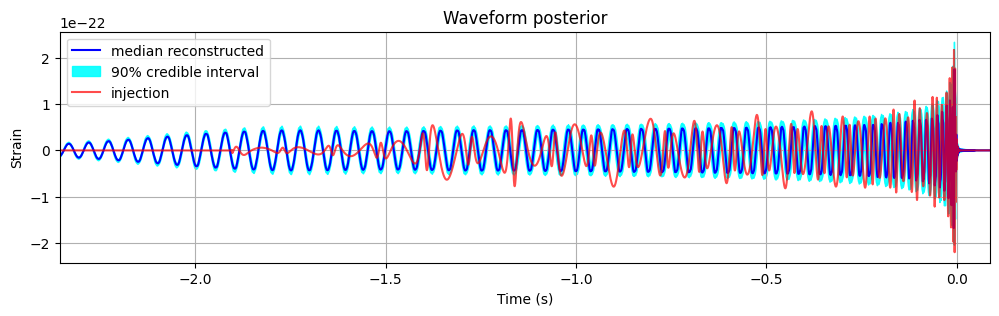

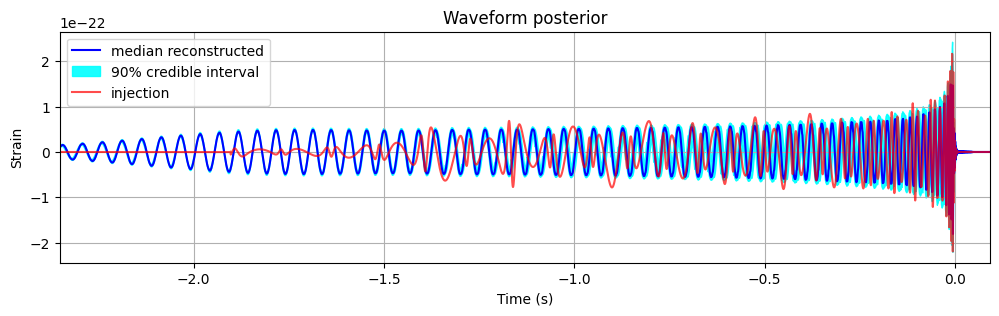

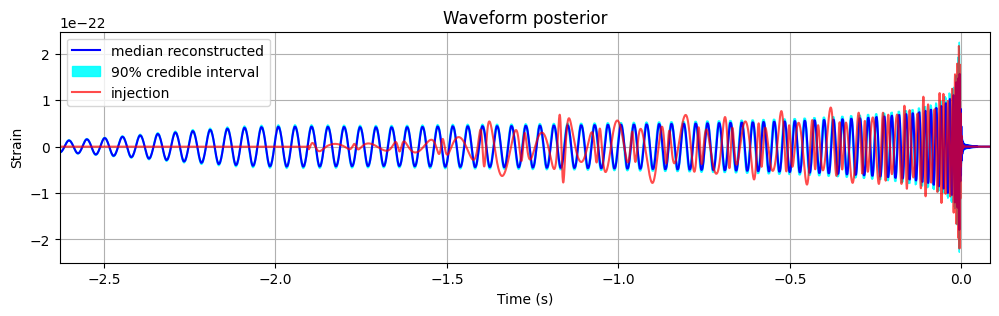

In [48]:
wp.plot_waveform_posterior_in_dir_for_all_runs(os.path.join(base_dir, 'hybrids', 'BBH_1370'), 
                                               inj_channel_name_without_ifo='BBH_1370')


 /home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/hybrids/BBH_1364/zero_noise/inj1/run02/posterior.hdf
n_samples = 100
Generating templates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.53it/s]


Plotting waveform

 /home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/hybrids/BBH_1364/zero_noise/inj1/run03/posterior.hdf
n_samples = 100
Generating templates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.21it/s]


Plotting waveform

 /home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/hybrids/BBH_1364/zero_noise/inj1/run04/posterior.hdf
n_samples = 100
Skipping runs with TaylorF2Ecc

 /home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/hybrids/BBH_1364/zero_noise/inj1/run01/posterior.hdf
n_samples = 100
Generating templates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.66it/s]


Plotting waveform


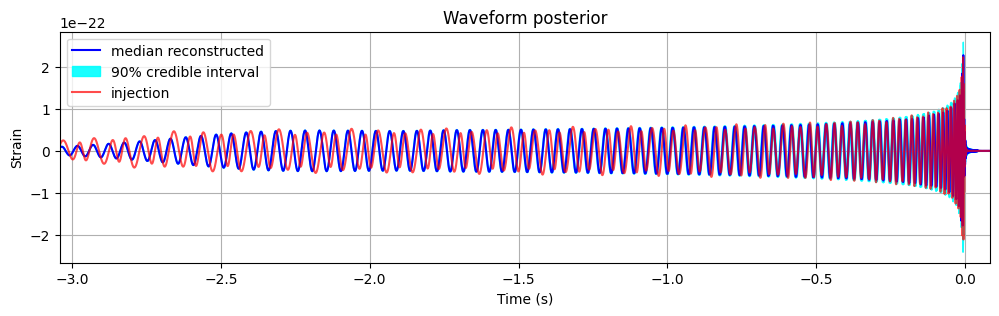

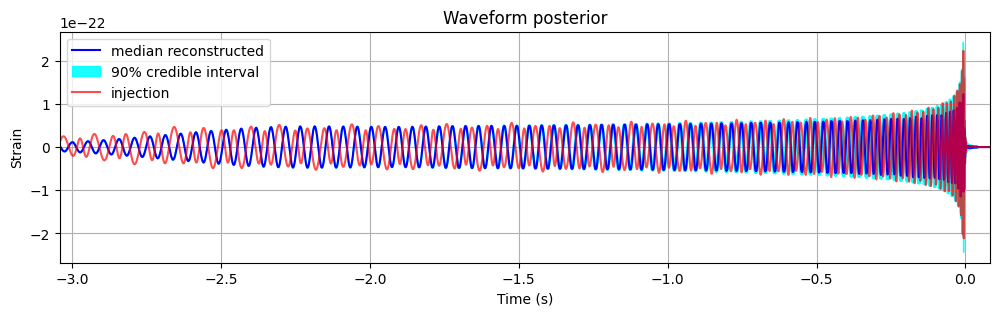

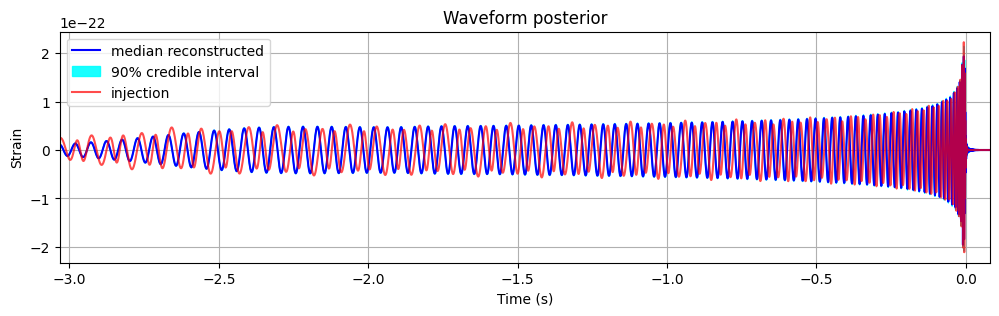

In [50]:
wp.plot_waveform_posterior_in_dir_for_all_runs(os.path.join(base_dir, 'hybrids', 'BBH_1364'), 
                                               inj_channel_name_without_ifo='BBH_1364')


 /home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/ICTS_sims/Lev3/EccPrecDiff002/zero_noise/inj1/run02/posterior.hdf
n_samples = 100
Skipping runs with TaylorF2Ecc

 /home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/ICTS_sims/Lev3/EccPrecDiff002/zero_noise/inj1/run01/posterior.hdf
n_samples = 100
Generating templates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.02it/s]


Plotting waveform


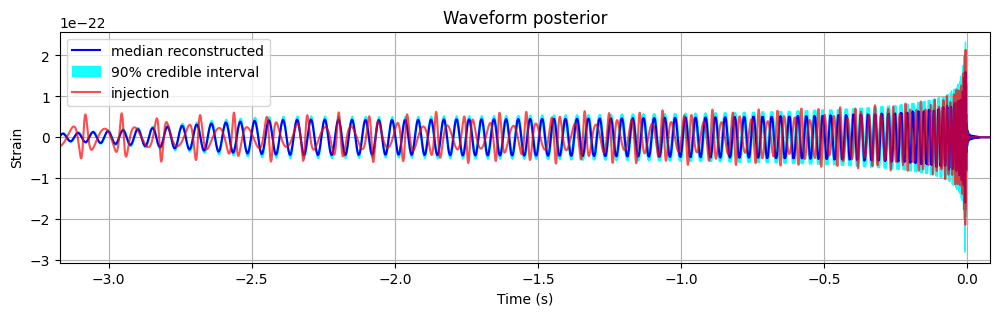

In [49]:
wp.plot_waveform_posterior_in_dir_for_all_runs(os.path.join(base_dir, 'ICTS_sims', 'Lev3', 'EccPrecDiff002'), 
                                               inj_channel_name_without_ifo='EccPrecDiff002')

In [45]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import pylab as plt
import deepdish as dd
import os
import numpy as np
import pycbc.conversions as convert
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
#from pycbc.coordinates.base import spherical_to_cartesian
from pycbc.coordinates import spherical_to_cartesian
from pycbc.frame import read_frame
import pycbc

In [46]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/hybrids'
hybrid_id = 'BBH_1374'
inj_num = 'inj1'
run_num = 'run03'
posterior_file = os.path.join(base_dir, hybrid_id, 'zero_noise', inj_num, run_num, 'posterior.hdf')

In [4]:
data = dd.io.load(posterior_file)
samples = data['samples']

In [5]:
maxL_idx = np.where(samples['loglikelihood']==max(samples['loglikelihood']))[0][0]
maxL_idx

7274

In [6]:
samples.keys()

dict_keys(['chi_eff', 'chi_p', 'coa_phase', 'dec', 'delta_tc', 'distance', 'eta', 'inclination', 'loglikelihood', 'logwt', 'mass1', 'mass2', 'mchirp', 'mtotal', 'q', 'ra', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'H1_lognl', 'L1_lognl', 'V1_lognl', 'lognl'])

In [7]:
data['sampling_params']

array(['delta_tc', 'mchirp', 'q', 'distance', 'coa_phase', 'inclination',
       'ra', 'dec', 'spin1_a', 'spin1_azimuthal', 'spin1_polar',
       'spin2_a', 'spin2_azimuthal', 'spin2_polar'], dtype=object)

In [9]:
spin1x_arr, spin1y_arr, spin1z_arr = spherical_to_cartesian(samples['spin1_a'], 
                                                            samples['spin1_azimuthal'], 
                                                            samples['spin1_polar'])
spin2x_arr, spin2y_arr, spin2z_arr = spherical_to_cartesian(samples['spin2_a'], 
                                                            samples['spin2_azimuthal'], 
                                                            samples['spin2_polar'])

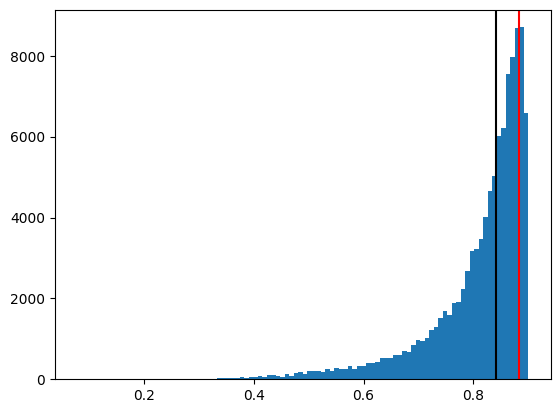

In [11]:
plt.hist(samples['chi_p'], bins=100);
plt.axvline(np.median(samples['chi_p']), c='k')
plt.axvline(samples['chi_p'][np.where(samples['mchirp']==np.median(samples['mchirp']))[0][0]], c='r')

In [13]:
samples.update({'spin1x':spin1x_arr, 
                'spin2x':spin2x_arr,
                'spin1y':spin1y_arr,
                'spin2y':spin2y_arr,
                'spin1z':spin1z_arr,
                'spin2z':spin2z_arr})

In [14]:
idx = np.where(samples['mchirp']==np.median(samples['mchirp']))[0][0]
print(convert.chi_p_from_spherical(samples['mass1'][idx], 
                             samples['mass2'][idx],
                             samples['spin1_a'][idx],
                             samples['spin1_azimuthal'][idx],
                             samples['spin1_polar'][idx],
                             samples['spin2_a'][idx],
                             samples['spin2_azimuthal'][idx],
                             samples['spin2_polar'][idx]))
print(samples['chi_p'][idx])
print(convert.chi_p(samples['mass1'][idx], 
                    samples['mass2'][idx],
                    samples['spin1x'][idx],
                    samples['spin1y'][idx],
                    samples['spin2x'][idx],
                    samples['spin2y'][idx]))

0.8827214392648859
0.8827214392648859
0.8827214392648859


In [15]:
np.where(samples['mchirp']==np.median(samples['mchirp']))[0][0]

37173

In [16]:
samples['distance'][np.where(samples['mchirp']==np.median(samples['mchirp']))]

array([595.48207083, 595.48207083, 595.48207083, 595.48207083,
       595.48207083, 595.48207083])

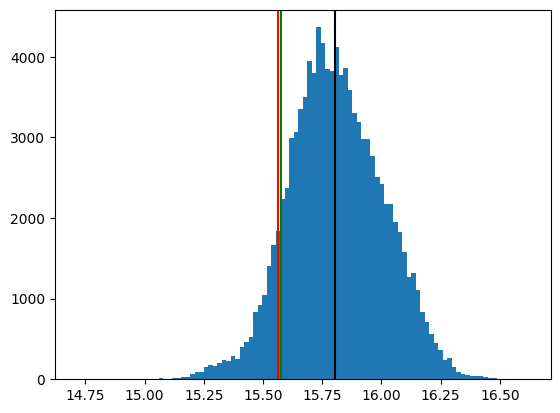

In [47]:
plt.hist(samples['mchirp'], bins=100);
plt.axvline(np.median(samples['mchirp']), c='k')
maxL_idx = np.where(samples['loglikelihood']==max(samples['loglikelihood']))[0][0]
plt.axvline(samples['mchirp'][maxL_idx], c='r')
plt.axvline(samples['mchirp'][logL_idx], c='green')

In [49]:
samples['loglikelihood'][maxL_idx]

-240.46926890415432

In [50]:
samples['loglikelihood'][logL_idx]

-247.9817407717087

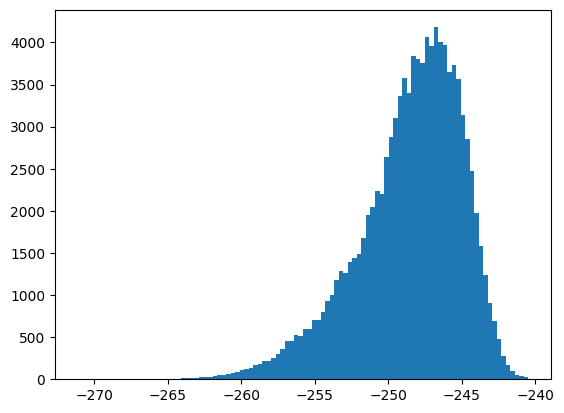

In [46]:
plt.hist(samples['loglikelihood'], bins=100);
logL_idx = np.where(samples['loglikelihood']==np.median(samples['loglikelihood']))[0][0]

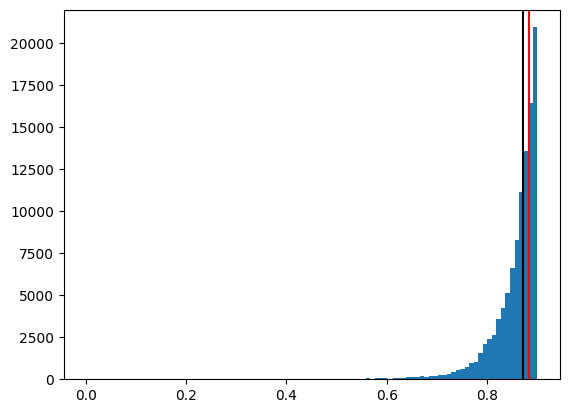

In [19]:
plt.hist(samples['spin1_a'], bins=100);
plt.axvline(np.median(samples['spin1_a']), c='k')
plt.axvline(samples['spin1_a'][idx], c='r')

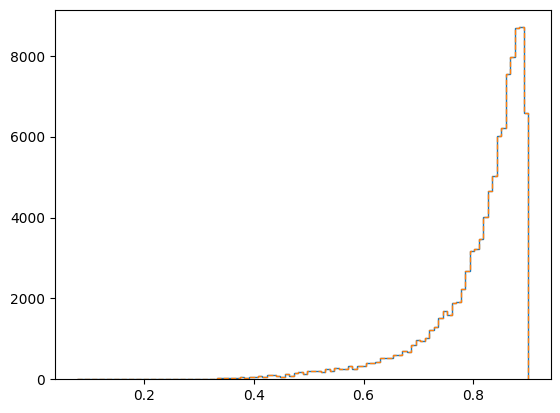

In [20]:
chip_arr = convert.chi_p(samples['mass1'], samples['mass2'], 
                          samples['spin1x'], samples['spin1y'], samples['spin2x'], samples['spin2y'])
plt.hist(samples['chi_p'], bins=100, histtype=u'step');
plt.hist(chip_arr, bins=100, histtype=u'step', ls='--');

In [37]:
idx = np.where(samples['mchirp']==np.median(samples['mchirp']))[0][0]
hp, hc = get_td_waveform(approximant = 'IMRPhenomXP', 
                         mass1 = samples['mass1'][idx],
                         mass2 = samples['mass2'][idx],
                         spin1x = samples['spin1x'][idx],
                         spin1y = samples['spin1y'][idx],
                         spin1z = samples['spin1z'][idx],
                         spin2x = samples['spin2x'][idx],
                         spin2y = samples['spin2y'][idx],
                         spin2z = samples['spin2z'][idx],
                         distance = samples['distance'][idx],
                         inclination = samples['inclination'][idx],
                         f_lower = data['f_lower'],
                         delta_t = 1/1024)
d = Detector('V1')
ht = d.project_wave(hp, hc, 
                    samples['ra'][idx], 
                    samples['dec'][idx], 
                    np.pi/3)

# t_peak_idx = np.argmax(np.abs(ht_arr))
# t_peak = t_arr[t_peak_idx]
# t_peak_to_end = t_arr[-1] - t_peak
# t_start_to_peak = t_peak - t_arr[0]
# print(f"Waveform ends {t_peak_to_end:f} seconds after peak.")
# print("Waveform length from start to peak =", t_start_to_peak)
# trig_time = 1137283217.0
#trig_time = 500

#t_shifted = (t_arr - t_arr[t_peak_idx])

ht_shifted = pycbc.waveform.TimeSeries(ht, delta_t=1/1024, epoch=data['trigger_time']-4.19)

In [38]:
V1_frame = read_frame(os.path.join(base_dir, hybrid_id, 'zero_noise', inj_num, 'V1.gwf'), 'V1:'+hybrid_id)

(1137283214.0, 1137283217.2)

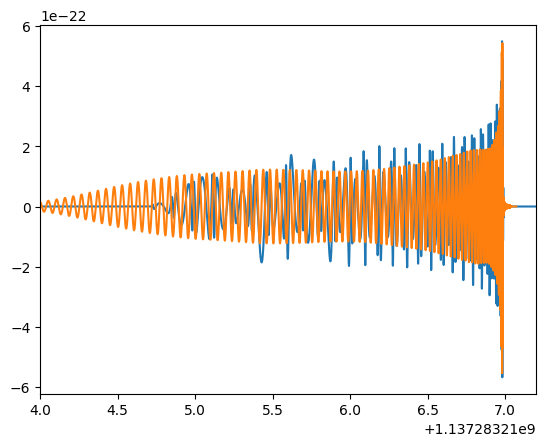

In [39]:
V1_frame.plot()
ht_shifted.plot()
plt.xlim(data['trigger_time']-3,data['trigger_time']+0.2)

In [62]:
convert.chi_p_from_spherical(np.median(samples['mass1']), np.median(samples['mass2']), 
                             np.median(samples['spin1_a']), 
                             np.median(samples['spin1_azimuthal']), 
                             np.median(samples['spin1_polar']),
                             np.median(samples['spin2_a']), 
                             np.median(samples['spin2_azimuthal']), 
                             np.median(samples['spin2_polar']))

0.8585843618299749

In [64]:
np.median(samples['chi_p'])

0.8407941363873774

In [59]:
convert.chi_p_from_spherical?

Signature:
convert.chi_p_from_spherical(
    mass1,
    mass2,
    spin1_a,
    spin1_azimuthal,
    spin1_polar,
    spin2_a,
    spin2_azimuthal,
    spin2_polar,
)
Docstring:
Returns the effective precession spin using spins in spherical
coordinates.
File:      ~/anaconda3/envs/pycbc_test/lib/python3.10/site-packages/pycbc/conversions.py
Type:      function

In [66]:
convert.chi_p(np.median(samples['mass1']), np.median(samples['mass2']),
              np.median(samples['spin1_a']*np.sin(np.median(samples['spin1_polar']))*np.cos(np.median(samples['spin1_azimuthal']))), 
              np.median(samples['spin1_a']*np.sin(np.median(samples['spin1_polar']))*np.sin(np.median(samples['spin1_azimuthal']))), 
              np.median(samples['spin2_a']*np.sin(np.median(samples['spin2_polar']))*np.cos(np.median(samples['spin2_azimuthal']))), 
              np.median(samples['spin2_a']*np.sin(np.median(samples['spin2_polar']))*np.sin(np.median(samples['spin2_azimuthal']))))

0.8585843618299749

In [63]:
convert.chi_p?

Signature: convert.chi_p(mass1, mass2, spin1x, spin1y, spin2x, spin2y)
Docstring:
Returns the effective precession spin from mass1, mass2, spin1x,
spin1y, spin2x, and spin2y.
File:      ~/anaconda3/envs/pycbc_test/lib/python3.10/site-packages/pycbc/conversions.py
Type:      function